# Cherry Blossom Data Analysis

## Introduction

The purpose of this analysis is to demonstrate the power of R in parsing data into the correct format. It does not delve into a detailed statistical analysis of the individual race results other than a simple comparison of the men's and women's times, as well as a few visualizations of the age distributions.

The data that we are analyzing here is the race completion time for all participants in the annual Washington, DC Cherry Blossom 10 mile race. We look at men and women for all years between 1999 and 2012, inclusive.

The data is in a fixed width format, though some formatting errors were introduced when it was converted to a web format. The data was gathered via webscraping using Python's `request` and `BeautifulSoup4` libraries, along with some human intervention when webscraping failed. We put the results pages into a Python list and noticed that the HTML format used placed the results inside a `<pre>` tag. Sometimes, the results would be further nested inside a `<font>` tag to change the fixed width font, but this was inconsistent, so we checked the contents of the tags before writing them to a text file.

We pulled all data that we could automatically, though some years were still not pulled properly by the script. For these years, we used a manual process of copy-pasting the results into a text file.

The Python notebook will be included along with this notebook as a reference.

A vimscript loaded each year and cleaned up results by removing `*` and `#` identifiers at the end of some participants' times, which were used to indicate the runner was outside the age guidelines for their group. The script also removed trailing comment lines and the introduction lines at the top, leaving only header row, the spacer row, and the records.

A second vimscript was used to clean a few other years, such as 2009, which contained misaligned columns. This was easily done by looking at the number of characters in a row and adding a space after the `Div/Tot` column for rows with too few characters. This fixed all the alignmnet issues in the data.

The script was modified to adjust for another year in which the Age column was not aligned properly in the data relative to the position for the header files.

## Pull data from files

The second step was to pull this data into files. The following scripts are heavily based on the unit 8 videos by Dr. McGee and the R script she referenced from <a href="http://www.rdatasciencecases.org/Runners/code.R">rdatasciencecases.org</a>.

The main difference is that these assume the data has not already been read in as a list of lines. Instead, we pass the name of the file. There is also a little extra cleaning at the end before the matrix is passed back.

In [44]:
select.cols <- function(col.names, header.row, search.locs) {
    sapply(col.names, function(name, header.row, search.locs) {
        start.pos <- regexpr(name, header.row)[[1]]
        if (start.pos == -1) {
            return(c(NA, NA))
        }
        
        index <- sum(start.pos >= search.locs)
        c(search.locs[index] + 1, search.locs[index + 1] - 1)
    }, header.row=header.row, search.locs=search.locs)
}

In [45]:
read.cherry <- function(file.name) {
    flat.file <- readLines(file.name)
    eq.index <- grep('^===', flat.file)
    
    spacer.row <- flat.file[eq.index]
    header.row <- tolower(flat.file[eq.index - 1])
    body <- flat.file[-(1:eq.index)]
    
    blank.locs <- gregexpr(" ", spacer.row)
    search.locs <- c(0, blank.locs[[1]])
    if (substr(spacer.row, nchar(spacer.row), nchar(spacer.row)) != " ") {
        search.locs <- c(search.locs, nchar(spacer.row))
    }
    
    short.col.names <- c("name", "home", "ag", "gun", "net", "time")
    loc.cols <- select.cols(short.col.names, header.row, search.locs)
    
    values <- mapply(substr, list(body), start=loc.cols[1,], stop=loc.cols[2,])
    colnames(values) <- short.col.names
    
    return(values)
}

### Read men's data

First we need to read the men's running data in. We know that we have every year from 1999 to 2012 stored in the `MenTxt` folder, so we can create a list and iterate through it with `lapply` to get a list of matrices.

In [46]:
men.files <- paste("MenTxt/", 1999:2012, ".txt", sep="")
men.files

[1] "MenTxt/1999.txt" "MenTxt/2000.txt" "MenTxt/2001.txt" "MenTxt/2002.txt"
 [5] "MenTxt/2003.txt" "MenTxt/2004.txt" "MenTxt/2005.txt" "MenTxt/2006.txt"
 [9] "MenTxt/2007.txt" "MenTxt/2008.txt" "MenTxt/2009.txt" "MenTxt/2010.txt"
[13] "MenTxt/2011.txt" "MenTxt/2012.txt"

In [47]:
men.data <- lapply(men.files, read.cherry)
length(men.data)

[1] 14

Now that we have the list of matrices, we need to convert these to data frames so the columns can have different data types. In particular, age should be an integer and the time columns will need to be converted into doubles for the number of minutes taken.

In [48]:
men.data <- lapply(men.data, as.data.frame)
class(men.data[[1]])

[1] "data.frame"

### Read women's data

Now we do the exact same process with the women's data.

In [49]:
women.files <- paste("WomenTxt/", 1999:2012, ".txt", sep="")
women.files

[1] "WomenTxt/1999.txt" "WomenTxt/2000.txt" "WomenTxt/2001.txt"
 [4] "WomenTxt/2002.txt" "WomenTxt/2003.txt" "WomenTxt/2004.txt"
 [7] "WomenTxt/2005.txt" "WomenTxt/2006.txt" "WomenTxt/2007.txt"
[10] "WomenTxt/2008.txt" "WomenTxt/2009.txt" "WomenTxt/2010.txt"
[13] "WomenTxt/2011.txt" "WomenTxt/2012.txt"

In [50]:
women.data <- lapply(women.files, read.cherry)
length(women.data)

[1] 14

In [51]:
women.data <- lapply(women.data, as.data.frame)
class(women.data[[1]])

[1] "data.frame"

## Convert age values to numeric

As we can see, the current data type for age is a factor.

In [52]:
class(women.data[[1]]$ag)

[1] "factor"

This doesn't make since because there is a true ordering to age values, and we expect that there is a relationship between age and performance, particularly as a longitudinal study with the same runner over the years of his/her participation.

Fortunately, the conversion process here is simple, as we only need to change the age column (`ag`) with `as.numeric` and return the data frame.

In [53]:
convert.age <- function(x) {
    x$ag <- as.numeric(as.character(x$ag))
    return(x)
}

men.data <- lapply(men.data, convert.age)
women.data <- lapply(women.data, convert.age)

class(women.data[[1]]$ag)

Warning message in FUN(X[[i]], ...):
"NAs introduced by coercion"

[1] "numeric"

As a final sanity check, we look at the data type for the first year of women's data to see that it has changed from `factor` to `numeric`.

# Convert time to numeric

The more challenging process is converting the time values. These are composed of many `NA`s and the rest are in `hh:mm:ss` format. However, for runners who took less than an hour to complete the race, times are only given in `mm:ss`. Therefore, we need to account for the number of colons encountered for each row. If the value is `NA`, we need to return it as-is, rather than imputing the data.

Future interesting work would be to impute the data by taking the average of the racer one rank above and one rank below the racer with the missing time. This should be the most accurate way to impute the data, because all racers have a ranking.

In [54]:
class(women.data[[1]]$time)

[1] "factor"

Once again, we see that the `time` column is a `factor`, but it should be `numeric`. To convert, we create a function `time.split` that is applied to each of gun time, net time, and time after converting each one to a `character` data type.

The resulting time strings are split on ":" and the values are converted into numbers. If there is an hour field, we convert it into minutes. We add this to the minutes field, if it exists. Finally, we add the seconds field (converted into fractions of minutes).

In [55]:
convert.time <- function(x) {
    time.split <- function(t) {
        if (is.na(t)) {
            return(NaN)
        }
        
        #tryCatch({
            split.time <- as.numeric(unlist(strsplit(t, split=":")))
            if (length(split.time) == 1) {
                return(split.time[[1]] / 60)
            } else if (length(split.time) == 2) {
                return(split.time[[1]] + split.time[[2]] / 60)
            } else if (length(split.time) == 3) {
                return(split.time[[1]] * 60 + split.time[[2]] + split.time[[3]] / 60)
            }    
        #}, error=function(error) {
        #    print(error)
        #    print(t)
        #})
    }
    
    x$gun <- sapply(as.character(x$gun), time.split)
    x$net <- sapply(as.character(x$net), time.split)
    x$time <- sapply(as.character(x$time), time.split)
    
    return(x)
}

This conversion function is then applied to each data frame in both the men and women's data. We wrap the `lapply` calls in `suppressWarnings()` because returning `NA` triggers several thousand warnings for rows that already had a value of `NA`.

In [56]:
suppressWarnings({
    men.data <- lapply(men.data, convert.time)
    women.data <- lapply(women.data, convert.time)

    class(women.data[[1]]$time)
})

[1] "numeric"

## Data exploration

The next step in the process is to visualize and explore the distributions of the data.

In [57]:
names(men.data) <- 1999:2012
names(women.data) <- 1999:2012

names(men.data)

[1] "1999" "2000" "2001" "2002" "2003" "2004" "2005" "2006" "2007" "2008"
[11] "2009" "2010" "2011" "2012"

In [58]:
head(men.data[[1]])

name,home,ag,gun,net,time
Worku Bikila,Ethiopia,28,NaN,NaN,46.98333
Lazarus Nyakeraka,Kenya,24,NaN,NaN,47.01667
James Kariuki,Kenya,27,NaN,NaN,47.05000
William Kiptum,Kenya,28,NaN,NaN,47.11667
Joseph Kimani,Kenya,26,NaN,NaN,47.51667
Josphat Machuka,Kenya,25,NaN,NaN,47.55000


### Men ages

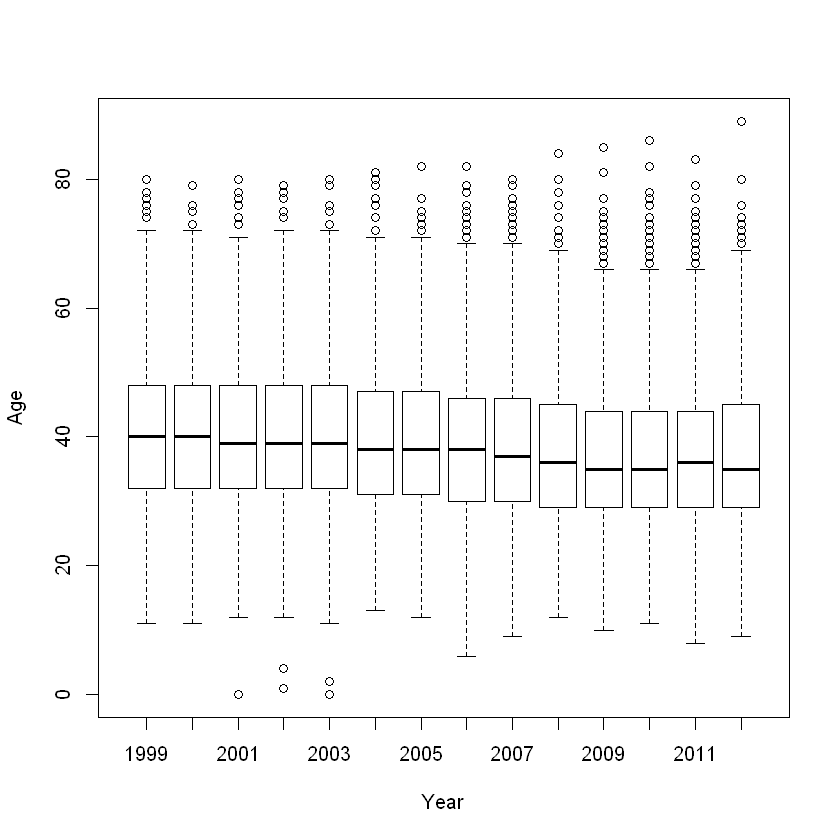

In [59]:
men.ages <- lapply(men.data, function(x) {as.numeric(x$ag)})
boxplot(men.ages, ylab="Age", xlab="Year")

### Women ages

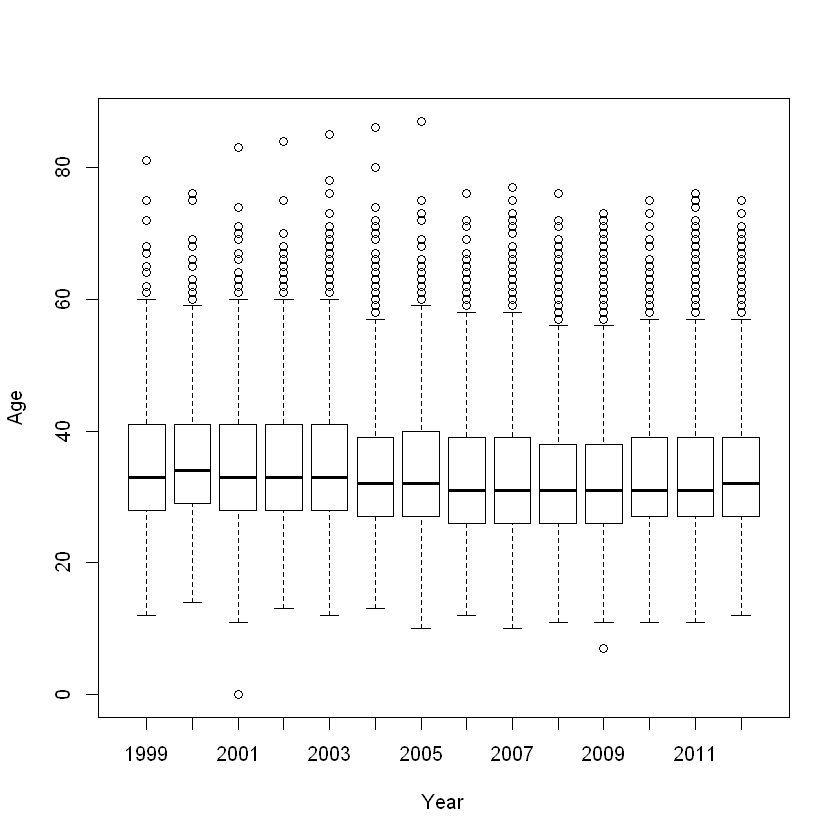

In [60]:
women.ages <- lapply(women.data, function(x) {as.numeric(x$ag)})
boxplot(women.ages, ylab="Age", xlab="Year")

All looks good with the ages with the exception of apparent 0 and `NA` values. We will clean those values in the data imputation section. 

### Men times

In [61]:
class(men.data[[2]]$net)

[1] "numeric"

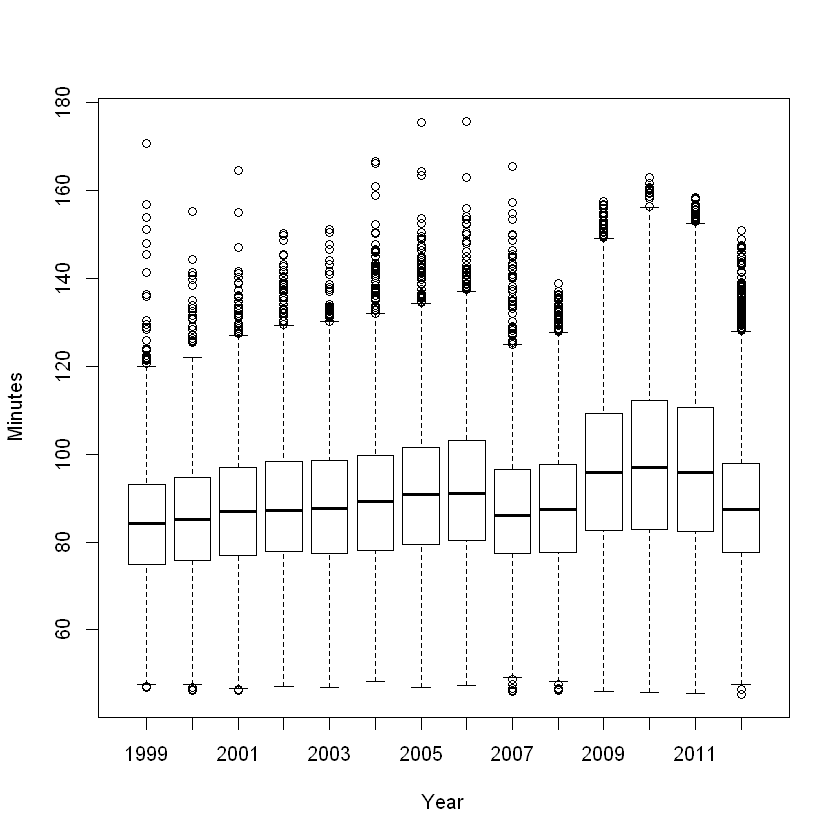

In [62]:
men.times <- lapply(men.data, function(x) {
    na.time <- sum(is.nan(x$time))
    na.gun <- sum(is.nan(x$gun))
    na.net <- sum(is.nan(x$net))
    
    least.missing <- min(c(na.time, na.gun, na.net))
    
    
    if (least.missing == na.time) {
        return(x$time)
    } else if (least.missing == na.gun) {
        return(x$gun)
    } else {
        return(x$net)
    }
})

boxplot(men.times, ylab="Minutes", xlab="Year")

### Women times

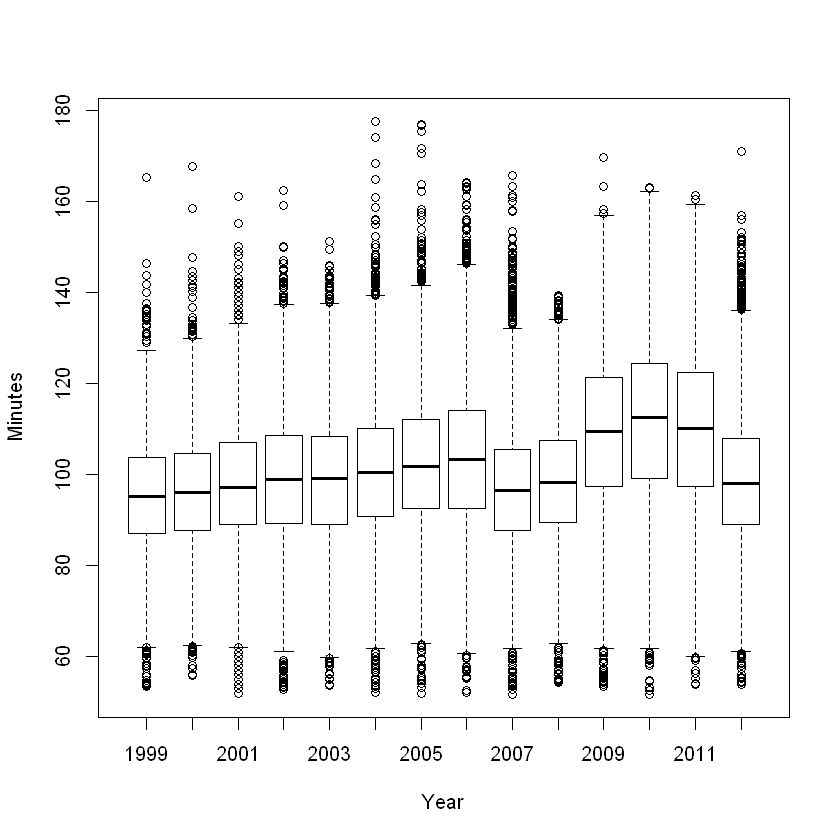

In [63]:
women.times <- lapply(women.data, function(x) {
    na.time <- sum(is.nan(x$time))
    na.gun <- sum(is.nan(x$gun))
    na.net <- sum(is.nan(x$net))
    
    least.missing <- min(c(na.time, na.gun, na.net))
    
    
    if (least.missing == na.time) {
        return(x$time)
    } else if (least.missing == na.gun) {
        return(x$gun)
    } else {
        return(x$net)
    }
})

boxplot(women.times, ylab="Minutes", xlab="Year")

## Data imputation

We see from the distribution plots that there are several missing age values. For these records, we impute with the average age for that year.

We also see that there are several participants who did not finish the race at all. It is impossible to guess at the times for these runners, so they have simply been removed from their datasets.

### Impute ages

In [64]:
lapply(men.data, function(x) {
    sum((x$ag < 10) | (is.na(x$ag)))
})

impute.ages <- function(x) {
    bad.ages <- (x$ag < 10) | (is.na(x$ag))
    x$ag[bad.ages] <- mean(x$ag, na.rm=TRUE)
    
    return(x)
}

men.data <- lapply(men.data, impute.ages)
women.data <- lapply(women.data, impute.ages)

lapply(men.data, function(x) {
    sum((x$ag < 10) | (is.na(x$ag)))
})

$`1999`
[1] 1

$`2000`
[1] 0

$`2001`
[1] 3

$`2002`
[1] 4

$`2003`
[1] 2

$`2004`
[1] 0

$`2005`
[1] 10

$`2006`
[1] 1

$`2007`
[1] 4

$`2008`
[1] 0

$`2009`
[1] 0

$`2010`
[1] 4

$`2011`
[1] 1

$`2012`
[1] 2

$`1999`
[1] 0

$`2000`
[1] 0

$`2001`
[1] 0

$`2002`
[1] 0

$`2003`
[1] 0

$`2004`
[1] 0

$`2005`
[1] 0

$`2006`
[1] 0

$`2007`
[1] 0

$`2008`
[1] 0

$`2009`
[1] 0

$`2010`
[1] 0

$`2011`
[1] 0

$`2012`
[1] 0

### Impute times

The first step is to find the best time values

In [65]:
add.real.times <- function(x) {
    na.time <- sum(is.nan(x$time))
    na.gun <- sum(is.nan(x$gun))
    na.net <- sum(is.nan(x$net))
    
    least.missing <- min(c(na.time, na.gun, na.net))
    
    
    if (least.missing == na.time) {
        x$real <- x$time
    } else if (least.missing == na.gun) {
        x$real <- x$gun
    } else {
        x$real <- x$net
    }
    
    return(x)
}

men.data <- lapply(men.data, add.real.times)
women.data <- lapply(women.data, add.real.times)

In [66]:
lapply(men.data, function(x) {
    sum(is.na(x$real))
})

impute.real.times <- function(x) {
    x <- x[!is.na(x$real),]
    
    return(x)
}

men.data <- lapply(men.data, impute.real.times)
women.data <- lapply(women.data, impute.real.times)

lapply(men.data, function(x) {
    sum(is.na(x$real))
})

$`1999`
[1] 0

$`2000`
[1] 0

$`2001`
[1] 2

$`2002`
[1] 0

$`2003`
[1] 0

$`2004`
[1] 0

$`2005`
[1] 0

$`2006`
[1] 1

$`2007`
[1] 22

$`2008`
[1] 0

$`2009`
[1] 0

$`2010`
[1] 0

$`2011`
[1] 0

$`2012`
[1] 0

$`1999`
[1] 0

$`2000`
[1] 0

$`2001`
[1] 0

$`2002`
[1] 0

$`2003`
[1] 0

$`2004`
[1] 0

$`2005`
[1] 0

$`2006`
[1] 0

$`2007`
[1] 0

$`2008`
[1] 0

$`2009`
[1] 0

$`2010`
[1] 0

$`2011`
[1] 0

$`2012`
[1] 0

## Analysis

Now we would like to answer a few questions of the data.

### Average age between years

While some years appear to trend toward older runners, such as 1999, we would like to know whether this difference is statistically significant. Do some races actually have older runners that we cannot attribute to chance?

In [24]:
# Code goes here

### Average time between genders

Men and women typically have different run times for races. Some say that men do better in shorter races (sprints, etc.), while women often fare better in longer races (endurance running). We would like to see whether there is a statistically significant difference between the genders in a 10 mile race.

In [25]:
# Code goes here

### Average age between genders

There is another discussion about whether one gender had more stamina at older ages than another. To inspect this question, we need to know whether there is a statistically significant difference in age between the genders.

In [75]:
all.men <- rbind(men.data[[1]], men.data[[2]], men.data[[3]], men.data[[4]], men.data[[5]],
                 men.data[[6]], men.data[[7]], men.data[[8]], men.data[[9]], men.data[[10]],
                 men.data[[11]], men.data[[12]], men.data[[13]], men.data[[14]])

all.women <- rbind(women.data[[1]], women.data[[2]], women.data[[3]], women.data[[4]],
                   women.data[[5]], women.data[[6]], women.data[[7]], women.data[[8]],
                   women.data[[9]], women.data[[10]], women.data[[11]], women.data[[12]],
                   women.data[[13]], women.data[[14]])

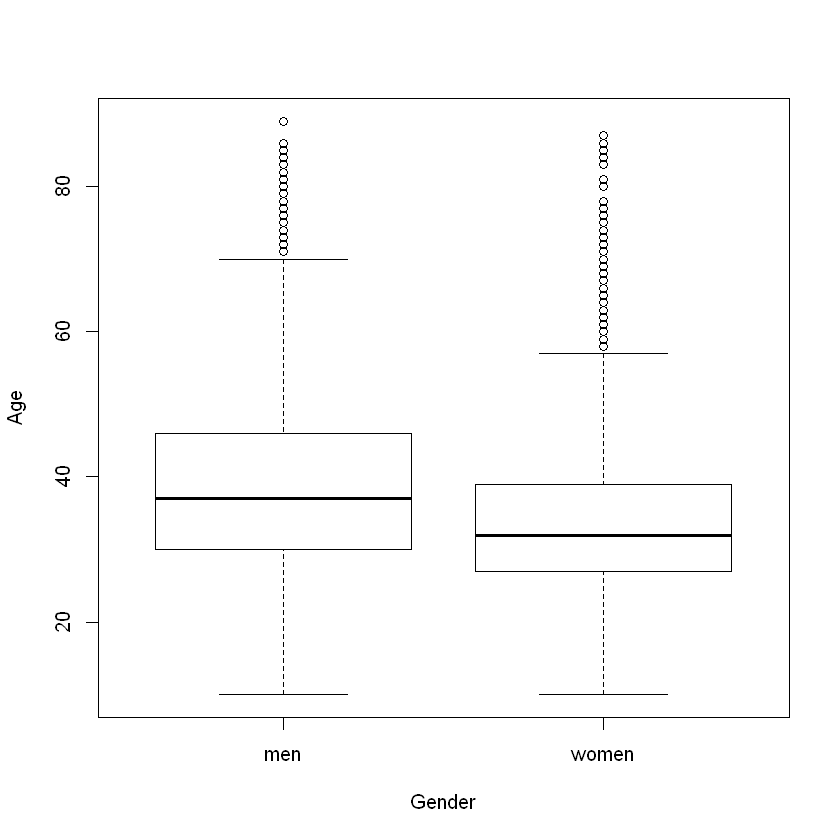

In [76]:
gender.ages <- list(men=all.men$ag, women=all.women$ag)
boxplot(gender.ages, ylab="Age", xlab="Gender")

The two distributions look approximately normal, so we don't see a need for any further data transformations.

In [77]:
t.test(gender.ages[[1]], gender.ages[[2]])


	Welch Two Sample t-test

data:  gender.ages[[1]] and gender.ages[[2]]
t = 89.84, df = 137800, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 4.658713 4.866519
sample estimates:
mean of x mean of y 
 38.61190  33.84928 


This shows that the mean age of male runners across all the years was 38.61, while the average age of female runners across all years was 33.85. The p-value is 2.2e-16, which means that there is strong evidence to suggest that the average age of male runners is greater than the average age of female runners.

The 95% confidence interval for the difference between the means is between 4.66 and 4.87.